# Creating, Training & Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix

#For Deep learning Libaries
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.compat.v1 import ConfigProto,InteractiveSession

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)
import pickle

In [3]:
from tqdm import tqdm
from keras.utils import to_categorical
input_path = "proc_input\\covid_data\\"

def process_data(img_dims, batch_size):
    #Data generation objects
    x_train, y_train = list(), list()
    x_test, y_test = list(), list()
    x_val, y_val = list(), list()
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    for cond in tqdm(['/NORMAL/', '/PNEUMONIA/', '/COVID/']):
        ipath = input_path + 'train' + cond 
        #print(ipath)
        for img in (os.listdir(input_path + 'train' + cond)):
            impath = input_path+'train'+cond+img
            try:
                imga = cv2.imread(impath) #load image from the specficic path
                imga = cv2.resize(imga, (img_dims, img_dims)) #resize the image to 155,155
                imga = np.dstack([imga])
                
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/PNEUMONIA/':
                    label = 1
                else:
                    label = 2
                x_train.append(imga)
                y_train.append(label)
            except:
                print('e')
   
    for cond in tqdm(['/NORMAL/', '/PNEUMONIA/',"/COVID/"]):
        for img in (os.listdir(input_path + 'test' + cond)):
            impath = input_path+'test'+cond+img
            try:
                imga = cv2.imread(impath) #load image from the specficic path
                imga = cv2.resize(imga, (img_dims, img_dims)) #resize the image to 155,155
                imga = np.dstack([imga])
                
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/PNEUMONIA/':
                    label = 1
                else:
                    label = 2
                x_test.append(imga)
                y_test.append(label)
            except:
                print('f')
    
    #to store the length
    len_xtrain = len(x_train)
    len_xtest = len(x_test)
   
   #255 is the range of color...divide just to range between 0 and 1 
    x_test  = np.asarray(x_test)/255.0 
    x_train = np.asarray(x_train)/255.0
    
    y_train = to_categorical(y_train, 3) #convert to binary class, with 3 classes
    y_test = to_categorical(y_test, 3)   #convert to binary class, with 3 classes
   

    #Generate batches of tensor image data for augmentation
    train_datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        horizontal_flip=True,
        height_shift_range=0.11,
        width_shift_range=0.11,
        rotation_range=8,
        shear_range=0.2,
        zoom_range=0.3,
        #brightness_range=(0.9, 1.1),
        fill_mode='constant')
    

    test_datagen=ImageDataGenerator()
    val_datagen=ImageDataGenerator()
    
    train_gen = train_datagen.flow(
        x_train, y_train,
        batch_size=batch_size)
    
    test_gen = test_datagen.flow(
        x_test, y_test,
        batch_size=16)
    
    return train_gen, test_gen, x_test, y_test, len_xtrain, len_xtest

In [13]:
# Hyperparameters
img_dims = 150
batch_size = 32

# Getting the data
train_gen, val_gen, x_test, y_test, len_xtrain, len_xval = process_data(img_dims, batch_size)

100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


In [21]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Build the model
def resnet_model(img_dims):
    input_tensor = Input(shape=(img_dims, img_dims, 3)) #150,150,3 #As each image is 150x150, 3 channel value(color)
    base_model = ResNet152V2(include_top=False, input_tensor=input_tensor)

    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) #dropout to avoid overfitting
    
    #Add a  layer with 4096 units
    x = Dense(2048, activation='relu',activity_regularizer=l1(0.0001))(x)
    x = Dropout(0.1)(x) 
    
    #Add a hidden layer with 2048
    x = Dense(1024, activation='relu',activity_regularizer=l1(0.0001))(x)
    x = Dropout(0.03)(x)
    
    #Add a hidden layer with 1024
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.03)(x)
    
    #Add a hidden layer with 512
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.01)(x)
    
    #Add a hidden layer with 64
    x = Dense(32, activation='relu')(x)
    

    #Output layer with 3 units, with softmax activation...softmax activation helps to take the output and turn into a probability distribution
    predictions = Dense(3, activation='softmax')(x)
 
 
    # the model where it will be trained
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [30]:
checkpoint = ModelCheckpoint(filepath='C:/Users/Bill Chen/Desktop/Hadrian_FYP/Hadrian_FYP/outputs/resnet.hdf5', save_best_only=True, save_weights_only=True, monitor='val_accuracy')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=2, mode='max',min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, mode='min')

model = resnet_model(img_dims)

#Train neural network
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

#SGD better generalizes than Adam. https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

weights = {0:.7, 1:1.53, 2:17}
print(weights)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']       

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 38, 38, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 19, 19, 512)  0           ['conv3_block1_out[0][0]',       
          

 conv3_block5_1_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 21, 21, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, 19, 19, 128)  147456      ['conv3_block5_2_pad[0][0]']     
          

                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 19, 19, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 19, 19, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 19, 19, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_blo

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 10, 10, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 10, 10, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 10, 10, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 10, 10, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 10, 10, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 10, 10, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 12, 12, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 10, 10, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 10, 10, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 10, 10, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 10, 10, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 10, 10, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 10, 10, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 10, 10, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 5, 5, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 5, 5, 2048)   0           ['conv5_block1_out[0][0]',       
          

In [31]:
hist = model.fit_generator(
               train_gen, steps_per_epoch=len_xtrain// batch_size, 
               epochs=200, validation_data=val_gen, 
               validation_steps=len_xval// batch_size,callbacks=[checkpoint,lr_reduce],class_weight = weights)

Epoch 1/200


C:\Users\Bill Chen\AppData\Local\Temp\ipykernel_5952\3530068210.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


530/530 [==============================] - 146s 260ms/step - loss: 1.4365 - accuracy: 0.5546 - val_loss: 7.8919 - val_accuracy: 0.0574 - lr: 0.0100
Epoch 2/200
530/530 [==============================] - 135s 255ms/step - loss: 0.9138 - accuracy: 0.7787 - val_loss: 6.4183 - val_accuracy: 0.0753 - lr: 0.0100
Epoch 3/200
530/530 [==============================] - 136s 256ms/step - loss: 0.6892 - accuracy: 0.8272 - val_loss: 2.8469 - val_accuracy: 0.3189 - lr: 0.0100
Epoch 4/200
530/530 [==============================] - 134s 252ms/step - loss: 0.5947 - accuracy: 0.8481 - val_loss: 5.4118 - val_accuracy: 0.1059 - lr: 0.0100
Epoch 5/200
530/530 [==============================] - 134s 252ms/step - loss: 0.5651 - accuracy: 0.8621 - val_loss: 7.1235 - val_accuracy: 0.0944 - lr: 0.0100
Epoch 6/200
530/530 [==============================] - 134s 252ms/step - loss: 0.4900 - accuracy: 0.8761 - val_loss: 7.9355 - val_accuracy: 0.0842 - lr: 0.0100
Epoch 7/200
530/530 [==============================]

Epoch 98/200
530/530 [==============================] - 133s 250ms/step - loss: 0.1437 - accuracy: 0.9530 - val_loss: 1.2155 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 99/200
530/530 [==============================] - 133s 250ms/step - loss: 0.1444 - accuracy: 0.9558 - val_loss: 0.5573 - val_accuracy: 0.8584 - lr: 1.0000e-04
Epoch 100/200
530/530 [==============================] - 133s 250ms/step - loss: 0.1468 - accuracy: 0.9529 - val_loss: 1.6017 - val_accuracy: 0.7028 - lr: 1.0000e-04
Epoch 101/200
530/530 [==============================] - 133s 250ms/step - loss: 0.1446 - accuracy: 0.9549 - val_loss: 2.3424 - val_accuracy: 0.6327 - lr: 1.0000e-04
Epoch 102/200
530/530 [==============================] - 134s 253ms/step - loss: 0.1434 - accuracy: 0.9554 - val_loss: 0.3285 - val_accuracy: 0.9018 - lr: 1.0000e-04
Epoch 103/200
530/530 [==============================] - 137s 258ms/step - loss: 0.1423 - accuracy: 0.9524 - val_loss: 0.4824 - val_accuracy: 0.8801 - lr: 1.0000e-04
Epoch 

530/530 [==============================] - 133s 252ms/step - loss: 0.1293 - accuracy: 0.9570 - val_loss: 0.7507 - val_accuracy: 0.8431 - lr: 1.0000e-04
Epoch 197/200
530/530 [==============================] - 133s 252ms/step - loss: 0.1346 - accuracy: 0.9564 - val_loss: 1.6519 - val_accuracy: 0.6977 - lr: 1.0000e-04
Epoch 198/200
530/530 [==============================] - 134s 252ms/step - loss: 0.1339 - accuracy: 0.9567 - val_loss: 0.7876 - val_accuracy: 0.8278 - lr: 1.0000e-04
Epoch 199/200
530/530 [==============================] - 134s 252ms/step - loss: 0.1292 - accuracy: 0.9579 - val_loss: 0.5107 - val_accuracy: 0.8776 - lr: 1.0000e-04
Epoch 200/200
530/530 [==============================] - 134s 252ms/step - loss: 0.1288 - accuracy: 0.9584 - val_loss: 2.4359 - val_accuracy: 0.6403 - lr: 1.0000e-04


In [32]:
model.load_weights("C:/Users/Bill Chen/Desktop/Hadrian_FYP/Hadrian_FYP/outputs/resnet.hdf5")
model.save("C:/Users/Bill Chen/Desktop/Hadrian_FYP/Hadrian_FYP/outputs/resnet")

INFO:tensorflow:Assets written to: C:/Users/Bill Chen/Desktop/Hadrian_FYP/Hadrian_FYP/outputs/resnet\assets


INFO:tensorflow:Assets written to: C:/Users/Bill Chen/Desktop/Hadrian_FYP/Hadrian_FYP/outputs/resnet\assets


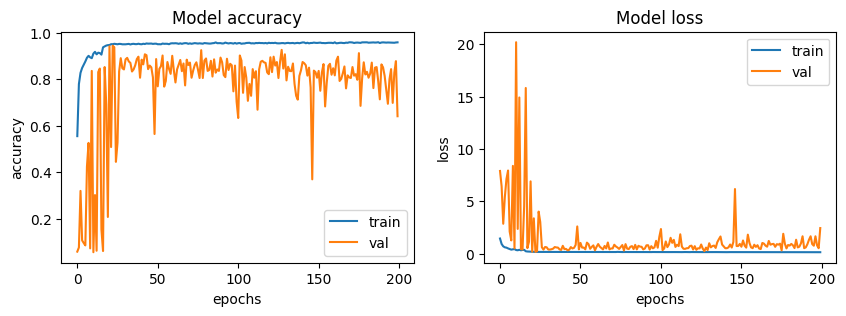

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
ax = ax.ravel()

for i, met in enumerate(["accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(x_test)

50/50 [==============================] - 6s 82ms/step


In [35]:
output1 = []
out_test = []

for i in range(len(preds)):
    output1.append(list(preds[i]).index(max(preds[i])))
    
for i in range(len(y_test)):
    out_test.append(list(y_test[i]).index(max(y_test[i])))

print(list(np.round(output1)).count(0)/len(output1))
print(list(out_test).count(0)/len(out_test))

0.5453400503778337
0.5579345088161209


In [36]:
accuracy = accuracy_score(out_test, output1)*100
print(accuracy)

94.64735516372797


In [37]:
cm = confusion_matrix(out_test, output1)
print("normal_sense= ", cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]))
print("pneumonia_sense= ", cm[1][1]/(cm[1][0]+cm[1][1]+cm[1][2]))
print("covid_sense= ", cm[2][2]/(cm[2][0]+cm[2][1]+cm[2][2]))

normal_sense=  0.9413092550790068
pneumonia_sense=  0.9485049833887044
covid_sense=  0.98


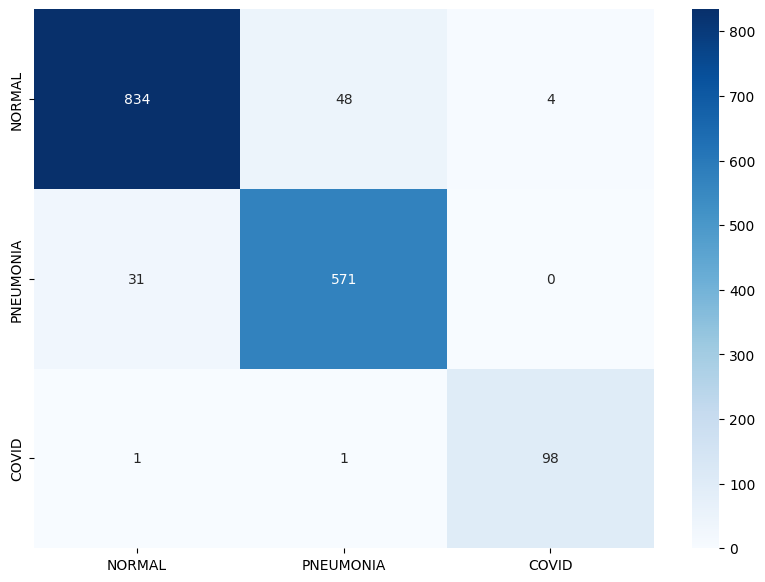

In [40]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i for i in ["NORMAL","PNEUMONIA","COVID"]],
                  columns = [i for i in ["NORMAL","PNEUMONIA","COVID"]])
plt.figure(figsize = (10,7))
x = sn.heatmap(df_cm, annot=True,fmt="d", cmap = "Blues")